# Week 46

In [1]:
try:
    import fysisk_biokemi
    print("Already installed")
except ImportError:
    %pip install -q "fysisk_biokemi[colab] @ git+https://github.com/au-mbg/fysisk-biokemi.git"

------------------------------------------------------------------------

## 1 Python: Introduction to curve fitting

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Curve fitting is a fundamental skill in biochemistry and biophysics for
analyzing experimental data. We use curve fitting to determine
parameters in mathematical models that describe biological processes
like enzyme kinetics, binding affinity, and reaction rates.

The basic idea is to find the parameters of a mathematical function that
best describes our experimental data.

#### (a) Understanding the problem

Real biochemical data is often requires complex fitting functions.
Therefore, we will start out with a simpler data that follows a linear
relationship. The data below represents a theoretical experiment where
we measure some output $y$ at different input values $x$:

In [3]:
## This makes two arrays (columns) ##
## One with the x coordinates ##
## One with the y coordinates ##
x_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y_data = np.array([2.1, 4.2, 6.0, 7.8, 10.1, 12.2, 13.9, 16.1, 18.0, 20.2])

The functions above simply make two arrays - i.e. columns of data -
containing the number. You can view the content of these colmns by with
`print(x_data)` or `print(y_data)`.

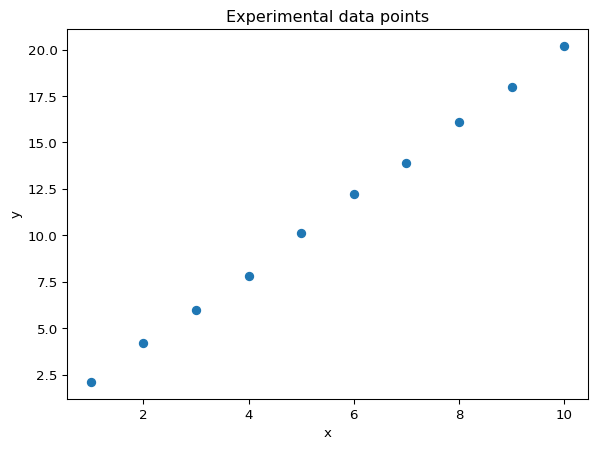

In [5]:
# Plot the data
fig, ax = plt.subplots()

## Your task: Plot the data as a scatter plot! ##
## Recall that you can do this with: ax.plot(x_data, y_data, 'o')
ax.plot(x_data, y_data, 'o')

## EXTRAS - You do not need to read or understand ##
## Adding customization ##
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Experimental data points');

Looking at this data, we can see it roughly follows a straight line.
Let’s assume our model is:

$$y = ax + b$$

where $a$ and $b$ are parameters we want to determine from the data.

#### (b) Defining a fitting function

To use `scipy.optimize.curve_fit`, we need to define a function where:

-   The **first** argument is the independent variable (x)  
-   The remaining arguments are the parameters to be fitted

Define a linear function for fitting:

In [7]:
def linear_function(x, a, b):
    ## Your task: Calculate the linear function ##
    result = a * x + b
    return result

Always a good idea to check that your function works as expected

As a test we are adding 1 in the place of x, 2 in the place of a and 0
in the place of b. In other words: $1 \cdot 2 + 0 = 2$

In [8]:
linear_function(1, 2, 0) # Should give 2

When in doubt it is a good idea to do sanity checks like this.

#### (c) Your first curve fit

Now we can use `curve_fit` to find the best parameters. The basic syntax
is:

``` python
fitted_parameters, trash = curve_fit(function, x_data, y_data, p0=initial_guess)
```

Where:

-   `function`: The function we defined above
-   `x_data`, `y_data`: Our experimental data
-   `p0`: Initial guess for parameters (optional but recommended)
-   `fitted_parameters`: The optimized parameters (what we want!)
-   `trash`: Don’t worry about this.

Finish the cell below to perform the curve fit by adding the three
missing arguments to the call to `curve_fit`.

In [10]:
# Initial guess: a=2, b=0
initial_guess = [2, 0]

# Perform the fit
fitted_parameters, trash = curve_fit(linear_function, x_data, y_data, p0=initial_guess)

# Extract parameters
a_fit, b_fit = fitted_parameters

print(fitted_parameters)
print(a_fit)
print(b_fit)

[2.00242424 0.04666667]
2.0024242424242424
0.04666666666666669

#### (d) Visualizing the fit

It’s crucial to always plot your fit to see how well it describes the
data. To do this we evaluate the function with the fitted parameters and
a densely sampled independent variable.

In [12]:
x_smooth = np.linspace(0, 11, 100) # Makes 100 equally spaced points between 0 and 11. 
y_fit = linear_function(x_smooth, a_fit, b_fit) # Call the linear function using x_smooth, a_fit and b_fit

Then we can plot it

Text(0.5, 1.0, 'Fit')

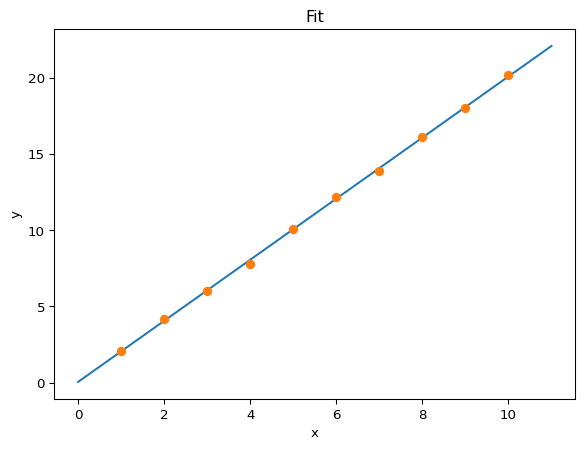

In [14]:
fig, ax = plt.subplots()

## Your task: Plot the fitted function using x_smooth and y_fit ##
ax.plot(x_smooth, y_fit)

## Plots the experimental data ##
ax.plot(x_data, y_data, 'o')

## EXTRA ##
## You do not need to understand this ##
## Customizes the plot ## 
ax.set_xlabel('x')
ax.set_ylabel('y') 
ax.set_title('Fit')

#### (e) Nonlinear fitting: Exponential decay

Many biological processes follow nonlinear relationships. Let’s work
with exponential decay, which is common in biochemistry (e.g.,
radioactive decay or unimolecular chemical reactions).

You can load the dataset from the `exp_decay_data.xlsx`-file with the
widget below

In [15]:
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [16]:
df = uploader.get_dataframe()
display(df)

In [17]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('exp_decay_data')
display(df)

Now make a plot of the data

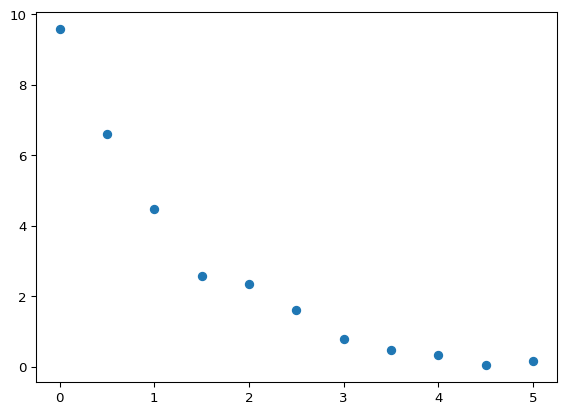

In [19]:
## Your task: Plot the data from the dataframe ´df´. ##
## Recall that your get the time-column as df['time'] ##
## Similarly you get the signal-column  as df['signal'] ##
fig, ax = plt.subplots()
ax.plot(df['time'], df['signal'], 'o')

The model we want to fit is: $$\text{signal} = A e^{-kt}$$

Define the exponential decay function:

In [21]:
def exponential_decay(t, A, k):
    ## Your task: Calculate the exponential function ##
    ## Remember that np.exp calculates the exponential function ##
    result = A * np.exp(-k * t)
    return result

## This calculates the function for t=1, A=1, k=1 ##
## If you did it correctly you should see 0.3678... ##
test_result = exponential_decay(1, 1, 1)
print(test_result)

0.36787944117144233

Now fit the exponential function to the data:

In [23]:
# Initial guess: A=8, k=1
initial_guess = [8, 1]

# Perform the fit
fitted_parameters, trash = curve_fit(exponential_decay, df['time'], df['signal'], p0=initial_guess)

# Extract parameters
A_fit, k_fit = fitted_parameters

print(A_fit)
print(k_fit)

9.627936471422466
0.7845023305388426

Again we should plot to check that it looks as expected

In [25]:
## This makes 100 linearly spaced points between 0 and 5 ##
t_smooth = np.linspace(0, 5, 100)

## Your task: Calculate the function using the fitted parameters and t_smooth ##
signal_fit = exponential_decay(t_smooth, A_fit, k_fit)

Now we can plot the fit along with the data.

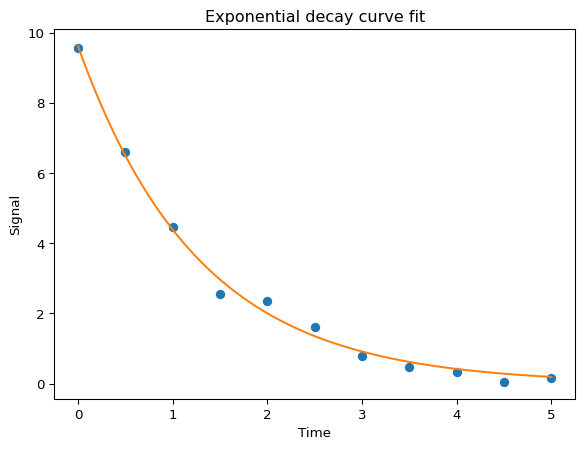

In [27]:
fig, ax = plt.subplots()

## Your task: Plot the observations - you can copy this line from the ## 
## previous plot. ##
ax.plot(df['time'], df['signal'], 'o')

## Your task: Plot the fit using t_smooth and signal_fit
ax.plot(t_smooth, signal_fit)

## EXTRA - You do not need to understand this ## 
## This adds customization ##
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Exponential decay curve fit')
plt.show()

------------------------------------------------------------------------

> **Key points for successful curve fitting:**
>
> 1.  **Always plot your data first** to understand what kind of
>     function might fit
> 2.  **Always plot the fit** to visually check if it makes sense
> 3.  **Check if parameters are reasonable** based on your biochemical
>     knowledge

> **Summary of `curve_fit`**
>
> Fitting refers to finding the parameters that make an assumed
> functional form best ‘fit’ the data.
>
> In Python we will use the `curve_fit` from the `scipy` package to do
> so. The function looks like this
>
> ``` python
> curve_fit(function, 
>             x_data, 
>             y_data, 
>             p0=[param_1, param_2, ...])
> ```
>
> The arguments are
>
> -   `function`: A python function where the **first** argument is the
>     independent variable (typically the x coordinate), and other
>     arguments are the parameters of the functions.
> -   `x_data`: The observed values of the independent variable (The x
>     coordinates).
> -   `y_data`: The observed values of the dependent variable (The y
>     coordinates) .
> -   `p0`: Initial guesses for the parameters.
>
> When called `curve_fit` starts by calculating how well the functions
> fits the data with the initial parameters in `p0` and then iteratively
> improves the fit by trying new values for the parameters in an
> intelligent way.
>
> The found parameters will generally depend on `p0` and it is therefore
> necessary to provide a good (or good enough) guess for `p0`.
>
> Generally, the best way to learn more about a function is to read it’s
> documentation and then play around with it. The documentation is in
> this case on the [SciPy
> website](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).
> You don’t need to read it, unless you want more details.

You now have the fundamental skills needed to fit curves to biochemical
data! In the exercises, you’ll apply these techniques to analyze real
experimental data and extract meaningful biological parameters.

------------------------------------------------------------------------

## 2 Estimation of binding affinity

#### (a) Train estimation skills

Train your estimation skills using the widget below.

In [28]:
from fysisk_biokemi.widgets.utils.colab import enable_custom_widget_colab
from fysisk_biokemi.widgets import estimate_kd

enable_custom_widget_colab()
estimate_kd()

#### (b) Compare to quadratic

The widget below shows the curves for $\theta$ using both the simple
expression assuming that $L = L_{tot}$ and the quadratic binding
expression. Vary $K_D$ and $P_{total}$ to work out a rule of thumb for
when the two equations give a similar curve.

In [29]:
from fysisk_biokemi.widgets.utils.colab import enable_custom_widget_colab
from fysisk_biokemi.widgets import visualize_simple_vs_quadratic

enable_custom_widget_colab()
visualize_simple_vs_quadratic()

In [30]:
answer = "They are equal when P_tot << K_D"

------------------------------------------------------------------------

## 3 Dialysis experiment

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 6)

A dialysis experiment was set up where equal amounts of a protein were
separately dialyzing against buffers containing different concentrations
of a ligand – each measurement was done in triplicate. The average
number of ligands bound per protein molecule, $\bar{n}$ were obtained
from these experiments. The corresponding concentrations of free ligand
and values are given in dataset `dialys-exper.xlsx`.

#### (a) Load the dataset

In [32]:
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [33]:
df = uploader.get_dataframe()
display(df)

In [34]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('dialysis_experiment') # Load from package for the solution so it doesn't require to interact.
display(df)

42 rows × 2 columns

#### (b) Explain calculation of $\bar{n}$

Explain how the values of $\bar{n}$ is calculated when knowing the
concentrations of ligand inside and outside the dialysis bag, as well as
the total concentration of the protein, \[$\text{P}_{\text{tot}}$\].

#### (c) Molar concentrations

Convert the concentrations of free ligand to SI-units given in M, add it
as a row to the `DataFrame`.

In [37]:
df['Free_ligand_(M)'] = df['Free_ligand_(uM)'] * 10**(-6)
display(df)

42 rows × 3 columns

#### (d) Plot the data

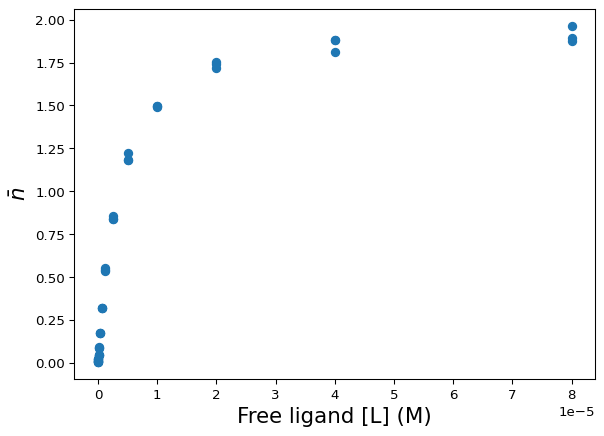

In [39]:
fig, ax = plt.subplots()

## Your task: Plot the raw data 
## With the ligand concentration df['Free_ligand_(M)'] on the x-axis
## And with n-bar df['n_bar'] on the y-axis.
ax.plot(df['Free_ligand_(M)'], df['n_bar'], 'o')

## EXTRAS: You do not need to understand this ## 
## This adds customization ##
ax.set_xlabel('Free ligand [L] (M)', fontsize=16)
ax.set_ylabel(r'$\bar{n}$', fontsize=16);

#### (e) Prepare for fitting

Now we want to fit the data to extract $K_D$ and $n$, by using the
equation

$$
\bar{n}([L_{\text{free}}]) = n \frac{[L_{\text{free}}]}{K_D + [L_{\text{free}}]}
$$

To do so we need to implmenet it as a Python function

In [41]:
def nbar(L, n, K_D):
    return n * L / (K_D + L)

## This calculates the function and prints for two different sets of values ## 
print(nbar(1, 1, 1)) # Should give 1/2
print(nbar(21, 47, 2.5)) # Should give 42

0.5
42.0

#### (f) Actually fitting

Finish the code to perform the fitting in the cell below.

In [43]:
from scipy.optimize import curve_fit

# Choose the variables from the dataframe
x = df['Free_ligand_(M)']
y = df['n_bar']

## Your task: Make initial guesses for the two parameters ## 
K_D_guess = 10**(-5)
n_guess = 1
initial_guess = [K_D_guess, n_guess]

## Your task: Give the four arguments in the correct order to make calculate ##
## the fitted parameters ##
fitted_parameters, pcov = curve_fit(nbar, x, y, initial_guess)

# Print the parameters
n_fit, K_D_fit = fitted_parameters
print(fitted_parameters)
print(n_fit)
print(K_D_fit)

[2.00882847e+00 3.39599709e-06]
2.008828473002213
3.3959970874778938e-06

Are the parameters you find reasonable? How can you tell if they are
reasonable by looking at the plot you made earlier?

#### (g) Plot with fit

When we have the fitted parameters we can calculate and plot the
function. To do so we make an array of values for the independent
variable and use our function to calculate the dependent variable

In [45]:
## This makes 50 equally spaced points ##
L_smooth = np.linspace(0, x.max()*1.2, 50) 

## Your task: Calculate the fitted function using the found parameters and L_smooth
nbar_calc = nbar(L_smooth, n_fit, K_D_fit)

Now that we calculated the dependent variable we can plot the fit along
with the data.

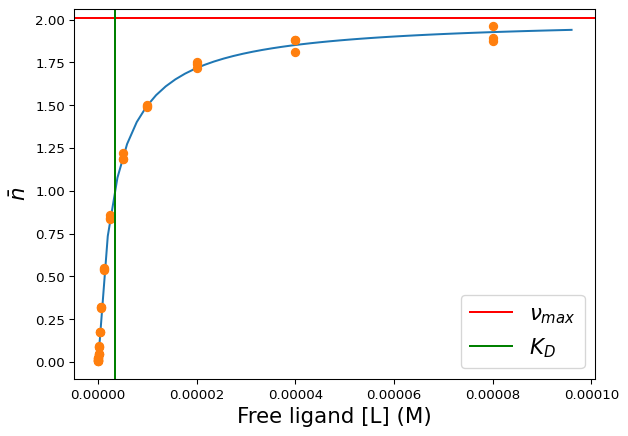

In [47]:
fig, ax = plt.subplots()

## Your task: Plot the fitted function ##
ax.plot(L_smooth, nbar_calc)

## Plots the data ## 
ax.plot(df['Free_ligand_(M)'], df['n_bar'], 'o')

## EXTRA: You do not need to understand this ## 
## This customizes the plot ## 
## It also adds lines indicating the values of n and K_D found ## 
ax.axhline(n_fit, color='red', label=r'$\nu_{max}$')
ax.axvline(K_D_fit, color='green', label=r'$K_D$')
ax.set_xlabel('Free ligand [L] (M)', fontsize=16)
ax.set_ylabel(r'$\bar{n}$', fontsize=16)
ax.legend(fontsize=16)

------------------------------------------------------------------------

## 4 Interpretation of binding data.

In [48]:
import numpy as np
import pandas as pd
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
pd.set_option('display.max_rows', 6)

The `inter-bindin-data.xlsx` contains a protein binding dataset.

#### (a) Load the dataset

Load the dataset using the widget below

In [49]:
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [50]:
df = uploader.get_dataframe()
display(df)

In [51]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('interpret_week48') # Load from package for the solution so it doesn't require to interact.
display(df)

45 rows × 2 columns

#### (b) SI Units

Add a new column to the `DataFrame` with the ligand concentration in SI
units.

In [53]:
## Your task: Add a column with the concentration in M ##
## Call this column df['[L]_(M)'] ##
## Recall that you can say df['[L]_(M)'] = df["[L]_(uM)"] * XXX ##
## Where XXX is the factor to multiply by. ##
df['[L]_(M)'] = df["[L]_(uM)"] * 10**(-6)
display(df)

45 rows × 3 columns

#### (c) Plot the data

Make plots of the binding data directly with a linear and logarithmic
x-axis.

Estimate $K_D$ by visual inspection of these plots!

Text(0, 0.5, '$\\bar{n}$')

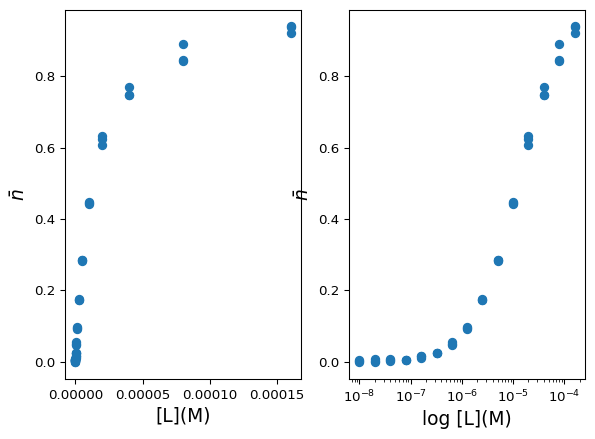

In [55]:
# This makes a figure with two axes.
fig, axes = plt.subplots(1, 2)

## We index with [0] to plot in the first axis. ## 
## Don't worry about remembering this ## 
ax = axes[0]
ax.plot(df['[L]_(M)'], df['nbar'], 'o')

## We index with [0] to plot in the first axis. ## 
## Don't worry about remembering this ## 
## We will make this a log plot ## 
ax = axes[1]

## Your task: Plot the data [L]_(M) vs nbar.
## Same exact code as above
ax = axes[1]
ax.plot(df['[L]_(M)'], df['nbar'], 'o')
ax.set_xscale('log')


## EXTRA: You do not need to understand this ## 
## Customization: Adds labels for the axis in both plots. 
ax = axes[0]
ax.set_xlabel('[L](M)', fontsize=14)
ax.set_ylabel(r'$\bar{n}$', fontsize=14)

ax = axes[1]
ax.set_xlabel('log [L](M)', fontsize=14)
ax.set_ylabel(r'$\bar{n}$', fontsize=14)

> **Note**
>
> Ths command `ax.set_xscale('log')` tells `matplotlib` that we want the
> x-axis to use a log-scale.

In [57]:
K_D_estimate = 5 * 10**(-5)

#### (d) Make a fit

Make a fit to determine $K_D$, as always we start by implementing the
function to fit with

In [59]:
def n_bar(L, K_D):
    ## Your task: Implement the function to fit with
    ## Use your biochemical knowledge to decide which function that is. 
    return L / (L + K_D)

And then we can make the fit

In [61]:
## Your task: Choose the variables from the dataframe ## 
x = df['[L]_(M)']
y = df['nbar']

# Initial guess
initial_guess = [K_D_estimate]

## Your task: Finish the curve fitting
fitted_parameters, trash = curve_fit(n_bar, x, y, initial_guess)

# Print the parameters
K_D_fit = fitted_parameters[0]
print(K_D_fit)

1.2457934647913883e-05

#### (e) Compare

Compare the fitted values with your guess.

In [63]:
## These lines make equally spaced points on a normal linear axis ##
## And on a logarithmic axis. ##
L_smooth = np.linspace(0, df['[L]_(M)'].max(), 100)
L_smooth_log = np.geomspace(df['[L]_(M)'].min(), df['[L]_(M)'].max(), 100)

## Youe task: Evaluate the fitted function with L_smooth and L_smooth_log ##
nbar_fit = n_bar(L_smooth, K_D_fit)
nbar_fit_log = n_bar(L_smooth_log, K_D_fit)

Now we can make a plot.

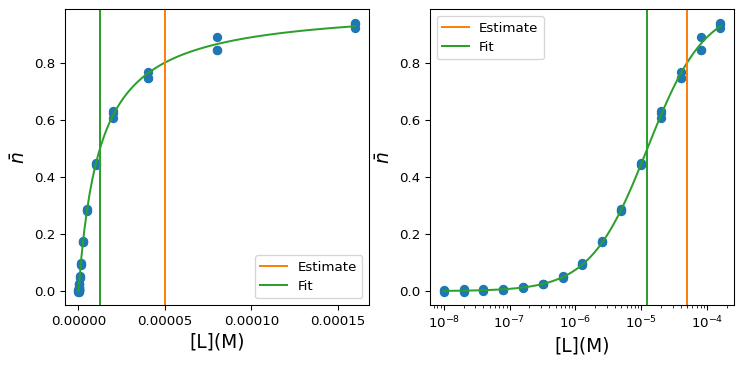

In [65]:
# This makes a figure with two axes.
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Index with [0] to plot in the first axis - Linear plot
ax = axes[0]
ax.plot(df['[L]_(M)'], df['nbar'], 'o', color='C0')
ax.plot(L_smooth, nbar_fit, color='C2')

ax.axvline(K_D_estimate, label='Estimate', color='C1')
ax.axvline(K_D_fit, label='Fit', color='C2')
ax.set_xlabel('[L](M)', fontsize=14)
ax.set_ylabel(r'$\bar{n}$', fontsize=14)
ax.legend()

# Index with [1] to plot in the second axis - Log plot.
ax = axes[1]
ax.plot(df['[L]_(M)'], df['nbar'], 'o', color='C0')
ax.plot(L_smooth_log, nbar_fit_log, color='C2')

ax.set_xlabel('[L](M)', fontsize=14)
ax.set_ylabel(r'$\bar{n}$', fontsize=14)
ax.axvline(K_D_estimate, label='Estimate', color='C1')
ax.axvline(K_D_fit, label='Fit', color='C2')
ax.legend()
ax.set_xscale('log')

#### (f) Saturation

Based on the value of $K_D$ found from the fit,

-   At which concentration do you expect 10% saturation?
-   At which concentration do you expect 90% saturation?

In [66]:
"""
At K_D/9 and 9*K_D.
"""

------------------------------------------------------------------------

## 5 Determination of type and strength of cooperativity

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
from scipy.optimize import curve_fit

The binding of NAD+ to the protein yeast glyceraldehyde 3-phosphate
dehydrogenase (GAPDH) was studied using equilibrium dialysis. The enzyme
concentration was 71 μM. The concentration of
$[\text{NAD}^{+}_\text{free}]$ and the corresponding values of $\bar{n}$
were determined with the resulting data found in the dataset
`deter-type-streng-coope.xlsx`.

The dataset consists of three independent repititions of the same
experiment.

#### (a) Load the dataset

Load the dataset using the widget below

In [68]:
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [69]:
df = uploader.get_dataframe()
display(df)

In [70]:
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('determination_coop_week48') # Load from package for the solution so it doesn't require to interact.
display(df)

9 rows × 4 columns

#### (b) Averaging and units.

Start by adding a new column to the `DataFrame` with the average value
of $\bar{n}$ across the three series

> **Tip**
>
> Remember that you can set a new column based on a computation using
> one or more other columns, e.g. 
>
> ``` python
> df['new_col'] = df['col1'] + df['col2']
> ```

In [72]:
## Your task: Calculate the of the values in the three columns ##
## nbar1, nbar2, nbar3 ##
df['nbar_avg'] = (df['nbar1'] + df['nbar2'] + df['nbar3']) / 3

Now also add a column with the ligand concentration in SI units with the
column-name `[NAD+free]_(M)`.

In [74]:
## Task: Calculate the ligand concentration in M and ##
## set it as a new column with the name '[NAD+free]_(M)'
df['[NAD+free]_(M)'] = df['[NAD+free]_(uM)'] * 10**(-6)
display(df)

9 rows × 6 columns

Finally, set the concentration of the GADPH in SI units

In [76]:
## Task: Convert the GADPH concentration to M  ## 
## Set it to the variable c_gadph ## 
## Add a comment about the unit ##
c_gadph = 71 * 10**(-6) # M

#### (c) Plot

Make a plot of the average $\bar{n}$ as a function of
$[\text{NAD}^{+}_\text{free}]$.

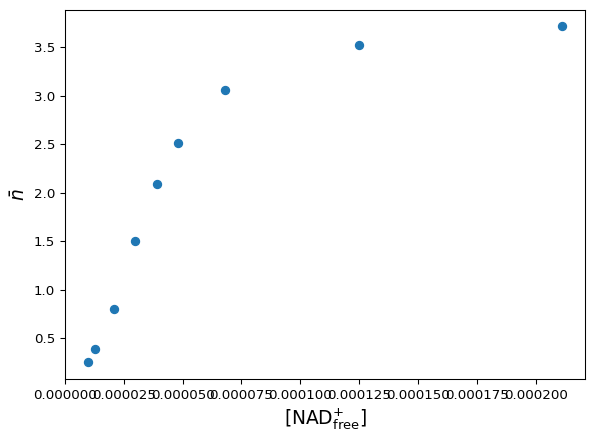

In [78]:
fig, ax = plt.subplots()

## Your task: Add plot of nbar vs [NAD+_free]_(M)
ax.plot(df['[NAD+free]_(M)'], df['nbar_avg'], 'o')

## EXTRA: You don't need to understand this
## Customization
ax.set_xlabel(r'$[\text{NAD}^{+}_\text{free}]$', fontsize=14)
ax.set_ylabel(r'$\bar{n}$', fontsize=14)
plt.show()

#### (d) Scatchard plot

Make a Scatchard plot based on the average $\bar{n}$.

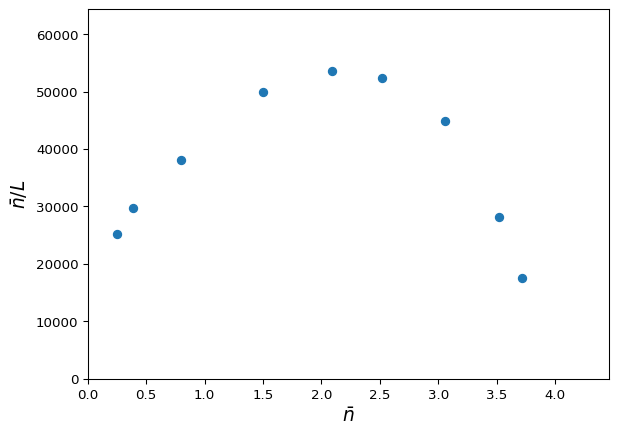

In [80]:
# Your task: Calculate nbar / L 
nbar_over_L = df['nbar_avg'] / df['[NAD+free]_(M)']

fig, ax = plt.subplots() 

# Your task: Choose the right things to make a Scatchard plot. 
ax.plot(df['nbar_avg'], nbar_over_L, 'o')

## EXTRA: You dont need to understand this. 
## Adds customization. 
ax.set_xlabel(r'$\bar{n}$', fontsize=14)
ax.set_ylabel(r'$\bar{n}/L$', fontsize=14)
ax.set_xlim([0, df['nbar_avg'].max()*1.2])
ax.set_ylim([0, nbar_over_L.max() * 1.2])

#### (e) Binding sites

Estimate by eye how many bindings sites GAPDH contains for
$\text{NAD}^{+}$?

In [81]:
"""
Saturation suggest assumptotic approximation to 4, which seems like the like 
intercept of the non-linear scatchard plot.
"""

#### (f) Cooperativity

Based on a visual inspection of the plot above, are there in signs of
cooperativity? If so, which kind?

In [82]:
"""
Positive cooperativity as witnessed e.g. by the increasing slope in the early 
part of the lienar plot
"""

#### (g) Fit

Make a fit using the functional form

$$
\bar{n} = N \frac{[L]^h}{K_D + [L]^h}
$$

As usual, start by defining the function in Python

In [84]:
def n_bar(L, N, K_D, h):
    ## Your task: Implement the function
    # Be careful with parentheses!
    result = N * L**h / (K_D + L**h)
    return result

Now we can fit

In [86]:
## We want to use all the data for the fit, but it was given in three different columns. 
## We stitch it together to make a column containing all x-coordinates 
## And another column containing all y-coordinates
x = np.concatenate([df['[NAD+free]_(M)'], df['[NAD+free]_(M)'], df['[NAD+free]_(M)']])
y = np.concatenate([df['nbar1'], df['nbar2'], df['nbar3']])

## Your task: Make initial guesses for the three parameters
## The order is that of the function 
## So N, K_D and h.
initial_guess = [1, 1, 1]

## Your task: Make the fit
## Note: The bounds argument has been added to have the function 
## only explore positive sets of parameters. 
fitted_parameters, trash = curve_fit(n_bar, x, y, initial_guess, bounds=(0, np.inf))

# Print the parameters
N_fit, K_D_fit, h_fit = fitted_parameters
print('N_fit', N_fit)
print('K_D_fit', K_D_fit)
print('h_fit', h_fit)

N_fit 3.997873553931702
K_D_fit 5.9798561894818436e-09
h_fit 1.8627077063542798

Do the fitted parameters support your intuitive reading of the type of
cooperativity?

> **Note**
>
> In the data sets used, repeated experiments were given as a three
> seperate columns, which is a quite natural way of recording data
> during an experiment. However, it is not an appropriate format for
> regression, where we want all the data-points in a single column. In
> this exercise we did a bit of *data wrangling* to make the data
> appropriate for what we want to do with it - in this case by creating
> a new joint column containing all the data by using the
> `np.concatenate` function.

------------------------------------------------------------------------

## 6 Competition in ligand binding

Below is given the general expression for saturation of a binding site
by one of the ligands, $L$, when two ligands $L$ and $C$ are competing
for binding to the same site on a protein. Assume that $[P_T] = 10^{-9}$
$\mathrm{M}$.

$$
\theta_L = \frac{[PL]}{[P_T]} = \frac{1}{\frac{K_D}{[L]}\left(1 + \frac{[C]}{K_C}\right) + 1}
$$

Consider these four situations

| \# | $[L_T]$ | $[C_T]$ | $K_D$ | $K_C$ |
|------|-----------------|-----------------|-----------------|-----------------|
| 1 | $1·10^{-3}$ $\mathrm{M}$ | $0$ | $1·10^{-5}$ $\mathrm{M}$ | $1·10^{-6}$ $\mathrm{M}$ |
| 2 | $1·10^{-3}$ $\mathrm{M}$ | $1·10^{-2}$ $\mathrm{M}$ | $1·10^{-5}$ $\mathrm{M}$ | $1·10^{-6}$ $\mathrm{M}$ |
| 3 | $1·10^{-3}$ $\mathrm{M}$ | $1·10^{-3}$ $\mathrm{M}$ | $1·10^{-5}$ $\mathrm{M}$ | $1·10^{-5}$ $\mathrm{M}$ |
| 4 | $1·10^{-5}$ $\mathrm{M}$ | $1·10^{-6}$ $\mathrm{M}$ | $1·10^{-5}$ $\mathrm{M}$ | $1·10^{-6}$ $\mathrm{M}$ |

##### (a) Explain simplification

Explain how the fact that $[P_T]$ is much smaller than $[L_T]$ and
$[C_T]$ simplifies the calculations using the above equation.

In [87]:
"""
When P(total) is << L(total) and C(total), we can assume that L(total) =[L] and C(total) = [C].
"""

#### (b) Ligand degree of saturation

Calculate the degree of saturation of the protein with ligand $L$ in the
four situations.

Start by writing a Python function that calculates the degree of
saturation $\theta$.

In [89]:
def bound_fraction(L, C, Kd, Kc):
    ## Your task: Write the equation for binding saturation. 
    ## Be careful with parentheses!
    theta = 1 / ((Kd / L)*(1+(C/Kc))+1) 
    return theta

Then use that function to calculate $\theta_L$ for each situation.

In [91]:
## Your task: Calculate the degree of saturation for each set of parameters ##
theta_L_1 = bound_fraction(10**(-3), 0, 10**(-5), 10**(-18))
theta_L_2 = bound_fraction(10**(-3), 10**(-2), 10**(-5), 10**(-6))
theta_L_3 = bound_fraction(10**(-3), 10**(-3), 10**(-5), 10**(-5))
theta_L_4 = bound_fraction(10**(-5), 10**(-6), 10**(-5), 10**(-6))

## Prints the results so we can analyze them.
print('Situation 1', theta_L_1)
print('Situation 2', theta_L_2)
print('Situation 3', theta_L_3)
print('Situation 4', theta_L_4)

Situation 1 0.9900990099009901
Situation 2 0.0099000099000099
Situation 3 0.49751243781094534
Situation 4 0.3333333333333333

#### (c) Competitor degree of saturation

What is the degree of saturation with respect to the competitor $C$ in
#1, #2, #3 and #4?

In [93]:
## Your task: Calculate the degree of saturation for each set of parameters ##
## Note: Now you are calculating it for the competitor!
theta_C_1 = 0 # [C] = 0
theta_C_2 = bound_fraction(10**(-2), 10**(-3), 10**(-6), 10**(-5))
theta_C_3 = bound_fraction(10**(-3), 10**(-3), 10**(-5), 10**(-5))
theta_C_4 = bound_fraction(10**(-6), 10**(-5), 10**(-6), 10**(-5))

## Prints the results so we can analyze them.
print('Situation 1', theta_C_1)
print('Situation 2', theta_C_2)
print('Situation 3', theta_C_3)
print('Situation 4', theta_C_4)

Situation 1 0
Situation 2 0.99000099000099
Situation 3 0.49751243781094534
Situation 4 0.3333333333333333

#### (d) Fraction of $[P_{\mathrm{free}}]$

What is the fraction of $[P_{\mathrm{free}}]$ in #1, #2, #3 and #4?

> **Tip**
>
> Consider how to express the fraction of $[P_{\mathrm{free}}]$ in terms
> of `theta_L_X` and `theta_C_X`.

In [95]:
theta_free_1 = 1 - (theta_L_1 + theta_C_1)
theta_free_2 = 1 - (theta_L_2 + theta_C_2)
theta_free_3 = 1 - (theta_L_3 + theta_C_3)
theta_free_4 = 1 - (theta_L_4 + theta_C_4)

## Prints the results so we can analyze them.
print('Situation 1', theta_free_1)
print('Situation 2', theta_free_2)
print('Situation 3', theta_free_3)
print('Situation 4', theta_free_4)

Situation 1 0.00990099009900991
Situation 2 9.900009900010165e-05
Situation 3 0.004975124378109319
Situation 4 0.33333333333333337

#### (e) Qualitative analysis

Describe in your own words why these four competitive situations end up
with their respective binding patterns. Consider the relative
concentrations and affinities of ligands L and C.

In [96]:
"""
1. The competitor concentration is zero, so only the ligand L binds. Affinity/concentration is such that nearly all proteins have an L-ligand bound.

2. The affinity and concentration of C is higher so it binds more and the ratio of affinity and concentration is high enough that nearly all proteins have a C-ligand bound. 

3. The affinity and concentration of L and C are equal and they both bind equally. Again, the affinities/concentrations are such that nearly all proteins have a ligand bound. 

4. K_D > K_C with the same factor as [L_T] > [C_T] so they bind equally but 
there are still free proteins as the concentrations are low relative to the affinities. 
"""

------------------------------------------------------------------------

## 7 Difference between $Q$ and $K_{eq}$

In [97]:
import matplotlib.pyplot as plt
import pandas as pd
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
pd.set_option('display.max_rows', 6)

Consider the reaction:

$$
A \rightleftarrows B
$$

The time course of the reaction was followed monitoring formation of the
product $B$. The starting concentration of $A$ was 50 µM, and as you
will learn later in the course, the reversible reaction going from $A$
to $B$ follows first order kinetics.

#### (a) Load & convert

The data is contained in the `diff_q_keq_data.xlsx` file.

In [98]:
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [99]:
df = uploader.get_dataframe()
display(df)

In [100]:
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('diff_q_keq') # Load from package for the solution so it doesn't require to interact.
display(df)

36 rows × 2 columns

Convert the measured concentrations of $B$, $[B]$, to concentrations in
the SI-unit $\mathrm{M} \ (\mathrm{mol/L})$. Repeat for the starting
concentration of $A$, $[A_0]$.

In [102]:
## Your task: Convert the concentration of B to M and set in new column ##
df['[B]_(M)'] = df['[B]_(uM)'] * 10**(-6) # Unit: M

## Your task: Set the initial concentration of A, in the variable A0.
## Remember to convert to M.
A0 = 50 * 10**(-6) # Unit: M 

#### (b) Law of mass balance

Use the laws of mass balance to calculate $[A]$ as a function of time in
the unit $\mathrm{M}$, add it as a column to the `DataFrame`

In [104]:
df['[A]_(M)'] = A0 - df['[B]_(M)']

Make a plot of the time vs. the concentration of $A$ and of time versus
the concentration of $B$.

Text(0, 0.5, 'Concentrations [M]')

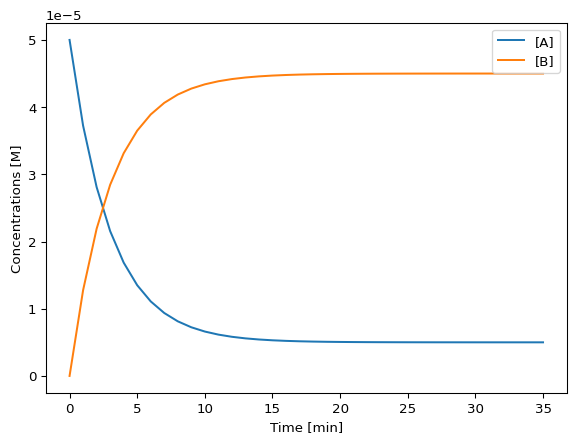

In [106]:
fig, ax = plt.subplots()
## Your task: Plot time vs. concentrations.
ax.plot(df['Time_(min)'], df['[A]_(M)'], label='[A]') # Time vs. concentration of A
ax.plot(df['Time_(min)'], df['[B]_(M)'], label='[B]') # Time vs. concentration of B

## This shows the labels.
ax.legend()

## EXTRA: You do not need to understand this: 
ax.set_xlabel('Time [min]')
ax.set_ylabel('Concentrations [M]')

#### (c) Mass action ratio

Calculate and plot the mass action ratio $Q$ as a function of time.

In [108]:
## Your task: Calculate the mass action ratio
Q = df['[B]_(M)'] / df['[A]_(M)']

Now plot the mass action ratio versus time.

Text(0, 0.5, 'Mass action ratio $Q$')

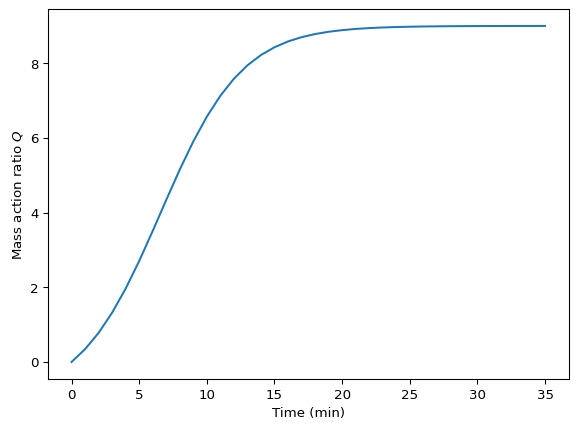

In [110]:
fig, ax = plt.subplots()

## Your task: Make a plot of the axis from the dataframe df['Time_(min)'] vs Q
ax.plot(df['Time_(min)'], Q)

## EXTRA: You do not need to understand this
## Adds customization.
ax.set_xlabel('Time (min)')
ax.set_ylabel('Mass action ratio $Q$')

#### (d) $Q$ vs $K_{eq}$

What is the difference between $Q$ and $K_{eq}$?

In [111]:
"""
Q is the mass action ratio at any time throughout the reaction. Keq is the mass 
action ratio at equilibrium only, and tells about the energetic favorisation of 
one direction over the other.
"""

#### (e) Favoured compound

Which of the two compounds $A$ and $B$ is favored at equilibrium?
(Favored: highest concentration)

In [112]:
"""
When the reaction reaches close to equilibrium, more B is present as compared to A, telling that B is favored. 
Keq > 1 --> B is favored
"""

#### (f) Equilibrium constant

What is the equilibrium constant of this reaction?

In [113]:
"""
Can also just read the concentrations values at eq from the graph and calculate K_eq from those. 
But it can of course also just be calculated.
"""
K_eq = df['[B]_(M)'][35] / df['[A]_(M)'][35]
print(K_eq)

8.999228315035122

------------------------------------------------------------------------

## 8 Determination of ΔH° for a reaction from the van’t Hoff plot.

In [114]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 

The equilibrium constant for a reversible reaction going from $A$ to $B$
was measured as a function of temperature.

The data obtained is given in the Excel document
`deter_delta_h_data.xlsx` - load the data with the widget

In [115]:
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [116]:
df = uploader.get_dataframe()
display(df)

In [117]:
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('deter_delta_h') # Load from package for the solution so it doesn't require to interact.
display(df)

#### (a) Transform & plot the data

> **Tip**
>
> In NumPy the `np.log` function calculates the natural logarithm that
> we often write as $\ln$ and `np.log10` calculates the base 10
> logarithm.

Add new columns to the `DataFrame` containing $\ln(K_{eq})$ and $1/T$
and make a plot with $1/T$ on the x-axis and $\ln(K_{eq})$ on the
y-axis.

In [119]:
## Your task: Add a column containing 1/T and one containing ln(Keq) ##
df['1/T'] = 1/df['T_(K)']
df['ln(Keq)'] = np.log(df['Keq'])

Now you can make the plot in the cell below

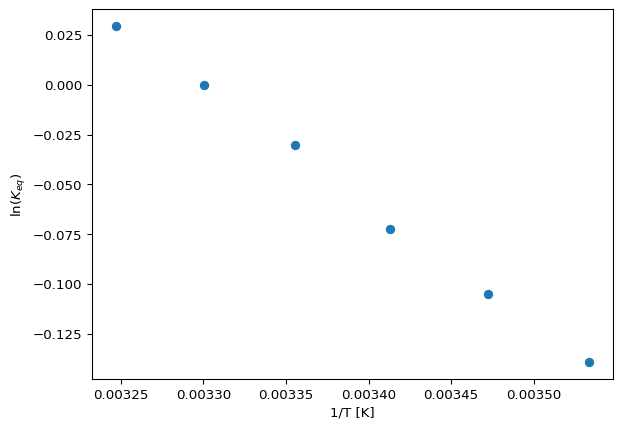

In [121]:
fig, ax = plt.subplots()

## Your task: Make a plot of 1/T vs ln(Keq)
ax.plot(df['1/T'], df['ln(Keq)'], 'o')

## EXTRA: Customization you don't need to edit or understand this
## It adds axis labels to the plot you made.
ax.set_xlabel(r'1/T [K]')
ax.set_ylabel(r'$\ln(K_{eq})$');

#### (b) Fit trendline

Make a linear trendline by fitting a linear function to the data.

Start by defining a linear function

In [123]:
def vant_hoff(T, a, b):
    ## Your task: Implement a linear function
    result = a * T + b
    return result

Now we can use regression to find the parameters

In [125]:
## Your task: Make a fit with curve_fit to find the parameters ##
fitted_parameters, trash = curve_fit(vant_hoff, df['1/T'], df['ln(Keq)'])
a_fit, b_fit = fitted_parameters

## Print ##
print(a_fit)
print(b_fit)

-599.0182388271635
1.975814074075527

Then make a plot with the trendline added

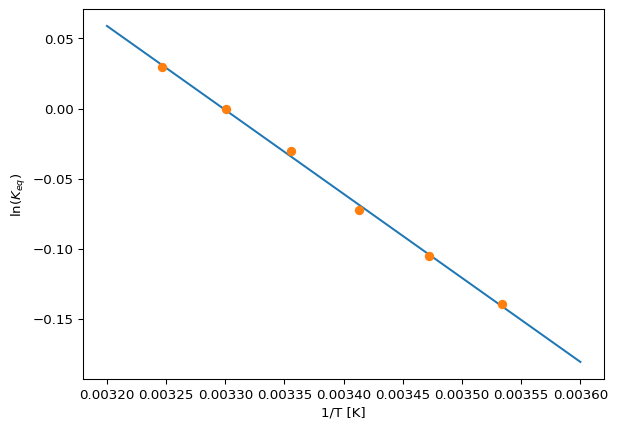

In [127]:
fig, ax = plt.subplots()

## Your task: Choose points to evaluate the fit
## Look at the x-axis above and estimate a value for the minimum and maximum. 
## Then calculate the fit at those points
max_x = 0.0032
min_x = 0.0036
T_trend = np.array([min_x, max_x])
y_fit = vant_hoff(T_trend, a_fit, b_fit)

## Your task: Plot the fit
ax.plot(T_trend, y_fit)

## Plots the data
ax.plot(df['1/T'], df['ln(Keq)'], 'o')

## EXTRA: You do not need to edit or understand this.
## It adds axis labels to the plot you made.
ax.set_xlabel('1/T [K]')
ax.set_ylabel(r'$\ln(K_{eq})$');

#### (c) Reaction type

Calculate the reaction enthalpy and entropy, at $T = 298 \ \mathrm{K}$,
assuming that
$R = 8.314472 \times 10^{-3} \ \frac{\mathrm{kJ}}{\mathrm{mol}\cdot\mathrm{K}}$.
Is the reaction endo- or exothermic?

In [128]:
## Your task: Set known values and add units as comments e.g. # kJ/(mol K) ##
R = 8.314472 * 10**(-3) # Unit: # kJ/(mol K)
T = 298 # Unit: K 


## Your task: Calculate ΔH and ΔS ##
## Consider the units!
dH = -R * a_fit # kJ/mol
dS = R * b_fit # kJ/(mol K)

print(dH)
print(dS)

4.980520374217764
0.016427850796106896

> **Tip**
>
> The units of a slope is the units of the y-axis dvided by the units of
> the x-axis.
>
> In the van’t Hoff plot the y-axis is unitless and the x-axis is in
> 1/K.

#### (d) Free energy change

Calculate the free energy change, $\Delta G^\circ$, at
$T = 298 \ \mathrm{K}$, assuming that
$R = 8.314472 \times 10^{-3} \ \frac{\mathrm{kJ}}{\mathrm{mol}\cdot\mathrm{K}}$

In [131]:
## Your task: Calculate ΔG
dG = dH - T * dS

print(dG)

0.08502083697790841

------------------------------------------------------------------------

## 9 ATP hydrolysis

In [132]:
import numpy as np

Below is shown the structure of ATP.

$\Delta G^\circ$ for the hydrolysis of ATP to ADP and Pi is
$-30.5 \ \mathrm{kJ/mol}$.

![](https://raw.githubusercontent.com/au-mbg/fysisk-biokemi/refs/heads/main/course/lessons/figures/atp_structure.png)

#### (a) $\Delta G$

In cells at $298 \ \mathrm{K}$ the steady state concentrations of ATP,
ADP og Pi resulted in a value for the reaction quotient
$Q = \frac{\mathrm{[ADP]}[\mathrm{Pi}]}{[\mathrm{ATP}]} = 0.002$.
Calculate ΔG’ under these conditions.

In [134]:
## Your task: Define known values
## Add units as comments! E.g. # kJ / mol
Q = 0.002
T = 298 # K
dG_std = -30.5 # kJ / mol
R = 8.314 * 10**(-3) # kJ /(mol K)

## Your task: Calculate dG
dG = dG_std + R*T*np.log(Q)
print(dG)

-45.89713901562406

#### (b) Equilibrium or not?

Assuming that the temperature within these cells is $298 \ \mathrm{K}$,
are these cells in equilibrium with respect to the hydrolysis of ATP?

In [136]:
K_eq = np.exp(-dG_std/(R*T))
print(K_eq)

222001.499219259

In [137]:
"""
Q is very different from this value, and therefore these cells are very far from 
equilibrium with respect to hydrolysis of ATP. This value of Q further favors the 
hydrolysis of ATP
"""

#### (c) ATP synthesized

Calculate the number of moles of ATP synthesized by a resting person in
a period of 24 hours, assuming that the energy consumption by this
person is $8368 \ \mathrm{kJ}$ per 24 hours and that 40% of this energy
is converted directly into ATP without loss of energy. Use the ΔG’ value
calculated in question a, and assume that $298 \ \mathrm{K}$.

In [139]:
# Your task: Set the known value of the energy spent for ATP.
energy_atp = 0.4 * 8368 # kJ

# Your task: Calculate the number of moles of ATP synthezied
synth_atp = energy_atp / np.absolute(dG)
print(synth_atp)

72.92829295657326

> **Tip**
>
> You can use `np.absolute` to calculate the absolute value of a number.

#### (d) Turnover

Next, calculate the average number of times each ATP molecule is turned
over (synthesis followed by hydrolysis) in 24 hours when the total
amount of ATP in the body equals $0.2 \ \mathrm{mol}$.

In [141]:
## Your task: Set the known total_atp value
total_atp = 0.2 # Unit: mol

## Your task: Calculate the turnover number.
turn_over = synth_atp / total_atp # Unit mol/mol -> Unitless
print(turn_over)

364.64146478286625